# Modules

In [1]:
import tensorflow as tf
import scipy
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG19
from keras.models import Sequential
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, Flatten, Dense, MaxPooling2D, BatchNormalization,AveragePooling2D, TimeDistributed, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 424113793373309817
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6284115968
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14535938997115636028
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Dataset preparation

In [5]:
batchsize = 8

In [9]:
# Training dataset

train_data_gen = ImageDataGenerator(rotation_range=0.2, 
                                        shear_range=0.2,
                                        zoom_range=0.2, 
                                        width_shift_range=0.2,
                                        height_shift_range=0.2, 
                                        rescale=1./255,
                                        validation_split=0.2)

train_data = train_data_gen.flow_from_directory('dataset/train', 
                                                    target_size=(80, 80), 
                                                    batch_size=batchsize, 
                                                    class_mode='categorical',
                                                    subset='training'
                                                    )

validation_data = train_data_gen.flow_from_directory('dataset/train', 
                                                    target_size=(80, 80), 
                                                    batch_size=batchsize, 
                                                    class_mode='categorical',
                                                    subset='validation'
                                                    )

Found 64719 images belonging to 2 classes.
Found 16179 images belonging to 2 classes.


In [10]:
# Testing dataset

test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory('dataset/test', 
                                                    target_size=(80, 80), 
                                                    batch_size=batchsize, 
                                                    class_mode='categorical', 
                                                    )

Found 4000 images belonging to 2 classes.


# Model preparation

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [19]:
# Base Model : InceptionV3

# Get knowledge from InceptionV3 pretrained model, so we don't need to train the model from scratch
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80, 80, 3)))
hmodel = bmodel.output
hmodel = Flatten()(hmodel)

# The only layers we need to train
# This is the layers' illustration https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fthe-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480&psig=AOvVaw0CYHQ2oruhWMmKK2Lxm5cN&ust=1668996857968000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCLDJs9TYu_sCFQAAAAAdAAAAABAU
hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(64, activation = "relu")(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(64, activation = "relu")(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2, activation='softmax')(hmodel)

modelInc = Model(inputs=bmodel.input, outputs=hmodel)

for layer in bmodel.layers:
    layer.trainable = False

checkpoint1 = ModelCheckpoint('models/InceptionV3', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=3)
    
print('done')

done


In [9]:
#Base Model : ResNet152V2

# Get knowledge from ResNet152V2 pretrained model, so we don't need to train the model from scratch
bmodel = ResNet152V2(include_top=False, weights='imagenet', input_tensor=Input(shape=(80, 80, 3)))
hmodel = bmodel.output
hmodel = AveragePooling2D(pool_size = (3,3))(hmodel)
hmodel = Flatten(name= 'flatten')(hmodel)

# The only layers we need to train
# This is the layers' illustration https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fthe-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480&psig=AOvVaw0CYHQ2oruhWMmKK2Lxm5cN&ust=1668996857968000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCLDJs9TYu_sCFQAAAAAdAAAAABAU

hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(64, activation = "relu")(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(64, activation = "relu")(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2, activation='softmax')(hmodel)

modelRes = Model(inputs=bmodel.input, outputs=hmodel)


for layer in bmodel.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint('models/ResNet152V2', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=3)

print('done')

done


In [20]:
modelInc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normalization[0][0]

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 7, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 7, 7, 96)     0           ['batch_normalization_10[0][0]'] 
          

                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 96)     55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 7, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 7, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 7, 7, 48)     0           ['batch_normalization_20[0][0]'] 
          

 conv2d_34 (Conv2D)             (None, 3, 3, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 3, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 3, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 3, 3, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 3, 3, 128)   384         ['conv2d_35[0][0]']              
 ormalizat

 activation_44 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 3, 3, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed4[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 3, 3, 160)   480         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_66 (Conv2D)             (None, 3, 3, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 3, 3, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 3, 3, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_61[0][0]'] 
          

                                                                                                  
 batch_normalization_74 (BatchN  (None, 3, 3, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
                                                                                                  
 conv2d_75

 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 1, 768)    0           ['activation_78[0][0]',          
          

                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activation_93 (Activation)     (None, 1, 1, 192)    0           ['batch_normalization_93[0][0]'] 
          

In [10]:
modelRes.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 42, 42, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 20, 20, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 20, 20, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 20, 20, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 10, 10, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 10, 10, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 10, 10, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 10, 10, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 12, 12, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 10, 10, 128)  147456      ['conv3_block5_2_pad[0][0]']     
                                                                                                  
 conv3_block5_2_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv3_block5_2_conv[0][0]']    
 ization) 

 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 10, 10, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 10, 10, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block8_1_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv3_block8_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 5, 5, 256)    589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 5, 5, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 5, 5, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 5, 5, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
          

                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 5, 5, 256)   1024        ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 5, 5, 256)   0           ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_pad (ZeroPaddin  (None, 7, 7, 256)   0           ['conv4_block5_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv4_block7_out (Add)         (None, 5, 5, 1024)   0           ['conv4_block6_out[0][0]',       
                                                                  'conv4_block7_3_conv[0][0]']    
                                                                                                  
 conv4_block8_preact_bn (BatchN  (None, 5, 5, 1024)  4096        ['conv4_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block8_preact_relu (Acti  (None, 5, 5, 1024)  0           ['conv4_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 5, 5, 256)    262144      ['conv4_block8_preact_relu[0][0]'
          

 conv4_block10_2_conv (Conv2D)  (None, 5, 5, 256)    589824      ['conv4_block10_2_pad[0][0]']    
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block10_2_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block13_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_pad (ZeroPaddi  (None, 7, 7, 256)   0           ['conv4_block13_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_blo

                                                                  'conv4_block15_3_conv[0][0]']   
                                                                                                  
 conv4_block16_preact_bn (Batch  (None, 5, 5, 1024)  4096        ['conv4_block15_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block16_preact_relu (Act  (None, 5, 5, 1024)  0           ['conv4_block16_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 5, 5, 256)    262144      ['conv4_block16_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block18_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block18_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block18_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block18_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block18_2_relu[0][0]']   
                                                                                                  
 conv4_block18_out (Add)        (None, 5, 5, 1024)   0           ['conv4_block17_out[0][0]',      
          

 conv4_block21_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block21_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block21_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block21_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block21_2_pad (ZeroPaddi  (None, 7, 7, 256)   0           ['conv4_block21_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block21_2_conv (Conv2D)  (None, 5, 5, 256)    589824      ['conv4_block21_2_pad[0][0]']    
          

                                                                                                  
 conv4_block24_preact_bn (Batch  (None, 5, 5, 1024)  4096        ['conv4_block23_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block24_preact_relu (Act  (None, 5, 5, 1024)  0           ['conv4_block24_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 5, 5, 256)    262144      ['conv4_block24_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block26_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block26_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block26_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block26_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block26_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block26_2_relu[0][0]']   
                                                                                                  
 conv4_block26_out (Add)        (None, 5, 5, 1024)   0           ['conv4_block25_out[0][0]',      
                                                                  'conv4_block26_3_conv[0][0]']   
          

 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_2_pad (ZeroPaddi  (None, 7, 7, 256)   0           ['conv4_block29_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block29_2_conv (Conv2D)  (None, 5, 5, 256)    589824      ['conv4_block29_2_pad[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block32_preact_bn (Batch  (None, 5, 5, 1024)  4096        ['conv4_block31_out[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 conv4_block32_preact_relu (Act  (None, 5, 5, 1024)  0           ['conv4_block32_preact_bn[0][0]']
 ivation)                                                                                         
                                                                                                  
 conv4_block32_1_conv (Conv2D)  (None, 5, 5, 256)    262144      ['conv4_block32_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block32_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block32_1_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 conv4_block34_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block34_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block34_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block34_2_relu[0][0]']   
                                                                                                  
 conv4_block34_out (Add)        (None, 5, 5, 1024)   0           ['conv4_block33_out[0][0]',      
                                                                  'conv4_block34_3_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv5_block1_1_bn (BatchNormal  (None, 3, 3, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 3, 3, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 5, 5, 512)   0           ['conv5_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 3, 3, 512)    2359296     ['conv5_block1_2_pad[0][0]']     
          

                                                                                                  
 conv5_block3_out (Add)         (None, 3, 3, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (BatchNormalization)   (None, 3, 3, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 3, 3, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['post_relu[0][0]']              
 ing2D)                                                                                           
          

# Train the model

In [11]:
# patience = max num of epochs when accuracy is not increasing
earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=2, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2)

callbacks = [checkpoint, earlystop, learning_rate]

In [21]:
# patience = max num of epochs when accuracy is not increasing
earlystop1 = EarlyStopping(monitor='val_loss', patience=7, verbose=2, restore_best_weights=True)

learning_rate1 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2)

callbacks1 = [checkpoint1, earlystop1, learning_rate1]

In [12]:
# Resnet152V2
opt = Adam(lr=1e-4, decay=1e-4 /50)
try:
    modelRes.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

    hsRes = modelRes.fit(train_data,
          steps_per_epoch=train_data.samples//batchsize,
          validation_data=validation_data,
          validation_steps=validation_data.samples//batchsize,
          callbacks=callbacks,
          epochs=50)
    
    modelRes.save('models/ResNet152V2/Resnet152V2_Drowsiness.h5')
except Exception as e:
    print(e)

Epoch 1/50


C:\Users\igosa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8088/8089 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8194
Epoch 1: val_loss improved from inf to 0.29869, saving model to models\ResNet152V2


INFO:tensorflow:Assets written to: models\ResNet152V2\assets


INFO:tensorflow:Assets written to: models\ResNet152V2\assets


8089/8089 [==============================] - 371s 45ms/step - loss: 0.3896 - accuracy: 0.8194 - val_loss: 0.2987 - val_accuracy: 0.8704 - lr: 1.0000e-04
Epoch 2/50
8089/8089 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9082
Epoch 2: val_loss did not improve from 0.29869
8089/8089 [==============================] - 320s 40ms/step - loss: 0.2305 - accuracy: 0.9082 - val_loss: 0.3460 - val_accuracy: 0.8252 - lr: 1.0000e-04
Epoch 3/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.2067 - accuracy: 0.9205
Epoch 3: val_loss improved from 0.29869 to 0.25764, saving model to models\ResNet152V2


INFO:tensorflow:Assets written to: models\ResNet152V2\assets


INFO:tensorflow:Assets written to: models\ResNet152V2\assets


8089/8089 [==============================] - 358s 44ms/step - loss: 0.2067 - accuracy: 0.9205 - val_loss: 0.2576 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 4/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9251
Epoch 4: val_loss did not improve from 0.25764
8089/8089 [==============================] - 317s 39ms/step - loss: 0.1961 - accuracy: 0.9251 - val_loss: 0.2607 - val_accuracy: 0.8817 - lr: 1.0000e-04
Epoch 5/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9291
Epoch 5: val_loss did not improve from 0.25764
8089/8089 [==============================] - 316s 39ms/step - loss: 0.1839 - accuracy: 0.9291 - val_loss: 0.2742 - val_accuracy: 0.8719 - lr: 1.0000e-04
Epoch 6/50
8089/8089 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9315
Epoch 6: val_loss did not improve from 0.25764

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
8089/8089 [==================

INFO:tensorflow:Assets written to: models\ResNet152V2\assets


INFO:tensorflow:Assets written to: models\ResNet152V2\assets


8089/8089 [==============================] - 358s 44ms/step - loss: 0.1655 - accuracy: 0.9377 - val_loss: 0.2509 - val_accuracy: 0.8893 - lr: 1.0000e-05
Epoch 9/50
8089/8089 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9385
Epoch 9: val_loss did not improve from 0.25090
8089/8089 [==============================] - 318s 39ms/step - loss: 0.1631 - accuracy: 0.9385 - val_loss: 0.2575 - val_accuracy: 0.8850 - lr: 1.0000e-05
Epoch 10/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9388
Epoch 10: val_loss did not improve from 0.25090
8089/8089 [==============================] - 313s 39ms/step - loss: 0.1616 - accuracy: 0.9389 - val_loss: 0.2596 - val_accuracy: 0.8846 - lr: 1.0000e-05
Epoch 11/50
8089/8089 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9405
Epoch 11: val_loss did not improve from 0.25090

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
8089/8089 [=============

In [22]:
# InceptionV3
opt = Adam(lr=1e-4, decay=1e-4 /50)
try:
    modelInc.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    hsInc = modelInc.fit(train_data,
          steps_per_epoch=train_data.samples//batchsize,
          validation_data=validation_data,
          validation_steps=validation_data.samples//batchsize,
          callbacks=callbacks1,
          epochs=50)
    
    modelInc.save('models/InceptionV3/InceptionV3_Drowsiness.h5')
except Exception as e:
    print(e)

Epoch 1/50


C:\Users\igosa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8089/8089 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8699
Epoch 1: val_loss improved from inf to 0.18069, saving model to models\InceptionV3


INFO:tensorflow:Assets written to: models\InceptionV3\assets


INFO:tensorflow:Assets written to: models\InceptionV3\assets


8089/8089 [==============================] - 219s 26ms/step - loss: 0.3072 - accuracy: 0.8699 - val_loss: 0.1807 - val_accuracy: 0.9254 - lr: 1.0000e-04
Epoch 2/50
8089/8089 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9224
Epoch 2: val_loss did not improve from 0.18069
8089/8089 [==============================] - 191s 24ms/step - loss: 0.2103 - accuracy: 0.9224 - val_loss: 0.1835 - val_accuracy: 0.9211 - lr: 1.0000e-04
Epoch 3/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9283
Epoch 3: val_loss improved from 0.18069 to 0.17647, saving model to models\InceptionV3


INFO:tensorflow:Assets written to: models\InceptionV3\assets


INFO:tensorflow:Assets written to: models\InceptionV3\assets


8089/8089 [==============================] - 214s 26ms/step - loss: 0.1928 - accuracy: 0.9283 - val_loss: 0.1765 - val_accuracy: 0.9295 - lr: 1.0000e-04
Epoch 4/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9316
Epoch 4: val_loss improved from 0.17647 to 0.17434, saving model to models\InceptionV3


INFO:tensorflow:Assets written to: models\InceptionV3\assets


INFO:tensorflow:Assets written to: models\InceptionV3\assets


8089/8089 [==============================] - 215s 27ms/step - loss: 0.1817 - accuracy: 0.9316 - val_loss: 0.1743 - val_accuracy: 0.9290 - lr: 1.0000e-04
Epoch 5/50
8087/8089 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9347
Epoch 5: val_loss improved from 0.17434 to 0.17308, saving model to models\InceptionV3


INFO:tensorflow:Assets written to: models\InceptionV3\assets


INFO:tensorflow:Assets written to: models\InceptionV3\assets


8089/8089 [==============================] - 241s 30ms/step - loss: 0.1746 - accuracy: 0.9347 - val_loss: 0.1731 - val_accuracy: 0.9295 - lr: 1.0000e-04
Epoch 6/50
8087/8089 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9357
Epoch 6: val_loss did not improve from 0.17308
8089/8089 [==============================] - 216s 27ms/step - loss: 0.1717 - accuracy: 0.9357 - val_loss: 0.1742 - val_accuracy: 0.9311 - lr: 1.0000e-04
Epoch 7/50
8087/8089 [============================>.] - ETA: 0s - loss: 0.1650 - accuracy: 0.9386
Epoch 7: val_loss did not improve from 0.17308
8089/8089 [==============================] - 213s 26ms/step - loss: 0.1649 - accuracy: 0.9386 - val_loss: 0.1857 - val_accuracy: 0.9227 - lr: 1.0000e-04
Epoch 8/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9406
Epoch 8: val_loss improved from 0.17308 to 0.16740, saving model to models\InceptionV3


INFO:tensorflow:Assets written to: models\InceptionV3\assets


INFO:tensorflow:Assets written to: models\InceptionV3\assets


8089/8089 [==============================] - 237s 29ms/step - loss: 0.1606 - accuracy: 0.9406 - val_loss: 0.1674 - val_accuracy: 0.9345 - lr: 1.0000e-04
Epoch 9/50
8089/8089 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9425
Epoch 9: val_loss did not improve from 0.16740
8089/8089 [==============================] - 213s 26ms/step - loss: 0.1563 - accuracy: 0.9425 - val_loss: 0.1865 - val_accuracy: 0.9225 - lr: 1.0000e-04
Epoch 10/50
8088/8089 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9417
Epoch 10: val_loss did not improve from 0.16740
8089/8089 [==============================] - 210s 26ms/step - loss: 0.1562 - accuracy: 0.9417 - val_loss: 0.1744 - val_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 11/50
8087/8089 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9433
Epoch 11: val_loss did not improve from 0.16740

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
8089/8089 [=============

# Model evaluation InceptionV3

In [23]:
hInc = hsInc.history

hInc.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

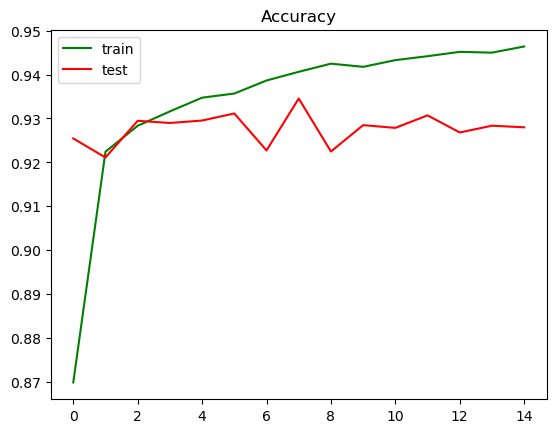

In [34]:
plt.title('Accuracy')
plt.plot(hInc['accuracy'] ,c = "green" , label = 'train' )
plt.plot(hInc['val_accuracy'] ,c = "red", label = 'test')
plt.legend()
plt.show()

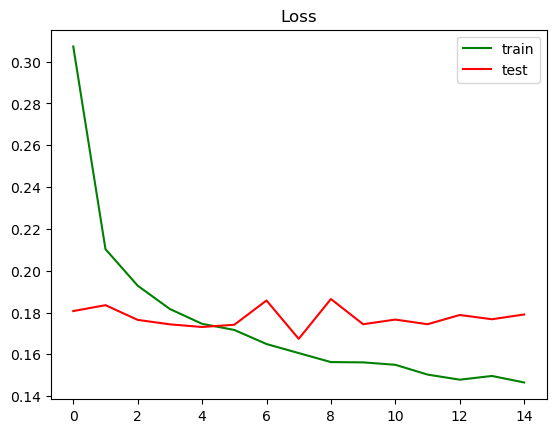

In [35]:
plt.title('Loss')
plt.plot(hInc['loss'] ,c = "green" , label = 'train')
plt.plot(hInc['val_loss'] ,c = "red", label = 'test')
plt.legend()
plt.show()

In [26]:
acc_training, loss_training = modelInc.evaluate(train_data)
print(acc_training)
print(loss_training)

8090/8090 [==============================] - 172s 21ms/step - loss: 0.1404 - accuracy: 0.9462
0.1403805911540985
0.9462445378303528


In [27]:
acc_val, loss_val = modelInc.evaluate(validation_data)
print(acc_val)
print(loss_val)

2023/2023 [==============================] - 44s 22ms/step - loss: 0.1666 - accuracy: 0.9347
0.16656893491744995
0.9346684217453003


In [11]:
from tensorflow.keras.models import load_model
model3 = load_model('models/InceptionV3//')
acc_test, loss_test = model3.evaluate(test_data)
print(loss_test)
print(acc_test)


500/500 [==============================] - 18s 19ms/step - loss: 0.4983 - accuracy: 0.8335
0.8335000276565552
0.49830979108810425


In [104]:
print(test_data.classes)
print(test_data.class_indices)

[0 0 0 ... 1 1 1]
{'closed_eyes': 0, 'open_eyes': 1}


1/1 [==============================] - 0s 43ms/step
0
The model detected it was a open eyes


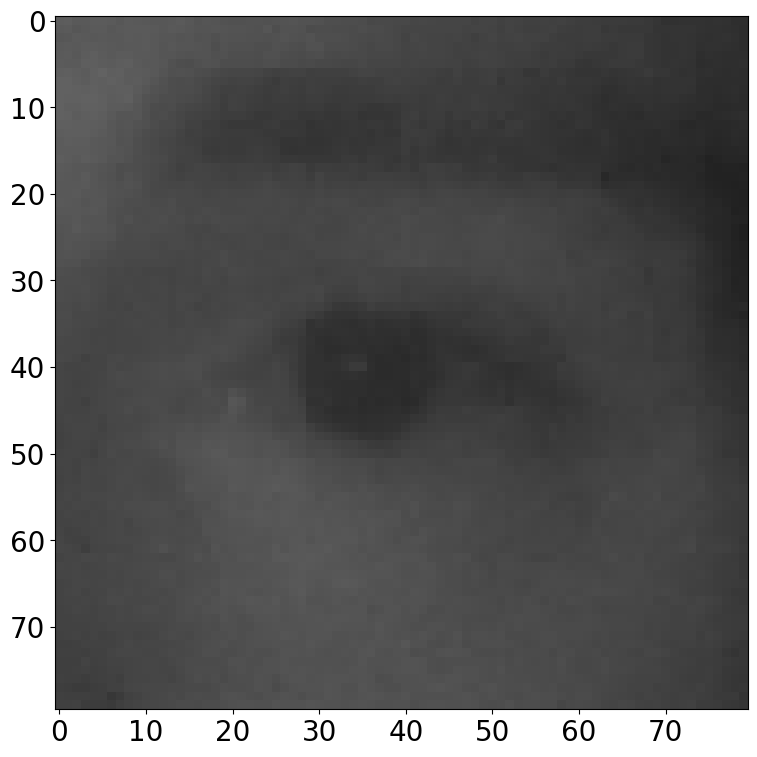

In [105]:
# Model Resnet & Inception :  0 =  open and 1 = closed 
from keras_preprocessing.image.utils import img_to_array , load_img
path = "C:/Users/igosa/Documents/GitHub/try_drowsiness_detection/jupyter/dataset/test/open_eyes/s0001_01902_0_0_1_0_0_01.png"
img = load_img(path, target_size=(80,80))
plt.imshow(img)
input_arr = img_to_array(img)/255

input_arr.shape

input_arr = np.expand_dims(input_arr , axis = 0)

predictions = (model1.predict(input_arr) > 0.5).astype("int32")

print(predictions[0][0])
if (predictions[0][0] == 1) : 
  print('The model detected it was a closed eyes')
else : 
  print ('The model detected it was a open eyes')

In [17]:
test_generator = ImageDataGenerator( rescale = 1/255)
test_data_generator = test_generator.flow_from_directory(
    'dataset/test',
     target_size=(80, 80),
    batch_size=batchsize,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model3.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

Found 4000 images belonging to 2 classes.
500/500 [==============================] - 10s 18ms/step
[0 0 0 ... 1 1 1]


In [18]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
print(class_labels)

['closed_eyes', 'open_eyes']


In [19]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

 closed_eyes       0.76      0.98      0.85      2000
   open_eyes       0.97      0.69      0.81      2000

    accuracy                           0.83      4000
   macro avg       0.86      0.83      0.83      4000
weighted avg       0.86      0.83      0.83      4000



In [20]:
probabilities = model3.predict(test_data_generator)
y_pred = np.argmax(probabilities, axis = 1)

print(confusion_matrix(test_data.classes, y_pred))

500/500 [==============================] - 9s 18ms/step
[[1957   43]
 [ 623 1377]]


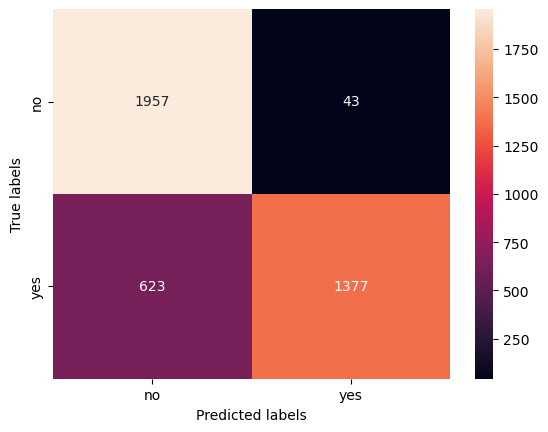

<Figure size 1200x800 with 0 Axes>

In [21]:
ax = plt.subplot() 
cf_matrix = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax= ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['no', 'yes']); ax.yaxis.set_ticklabels(['no', 'yes']);

# Model evaluation Resnet 152V2

In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('models/ResNet152V2//')
acc_training, loss_training = model1.evaluate(train_data)
print(acc_training)
print(loss_training)

8090/8090 [==============================] - 257s 32ms/step - loss: 0.1397 - accuracy: 0.9462
0.1396854668855667
0.9462445378303528


In [14]:
from tensorflow.keras.models import load_model
model1 = load_model('models/ResNet152V2//')
acc_val, loss_val = model1.evaluate(validation_data)
print(acc_val)
print(loss_val)

2023/2023 [==============================] - 64s 32ms/step - loss: 0.2526 - accuracy: 0.8873
0.25262168049812317
0.8872612714767456


In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('models/ResNet152V2//')
acc_test, loss_test = model1.evaluate(test_data)
print(acc_test)
print(loss_test)

500/500 [==============================] - 20s 34ms/step - loss: 0.2452 - accuracy: 0.9047
0.24521000683307648
0.9047499895095825


In [16]:
hRes = hsRes.history

hRes.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

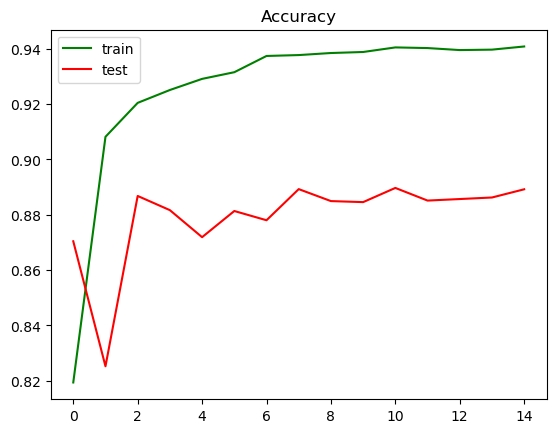

In [32]:
plt.title('Accuracy')
plt.plot(hRes['accuracy'] ,c = "green" , label='train' )
plt.plot(hRes['val_accuracy'] ,c = "red" ,label = 'test')
plt.legend()
plt.show()

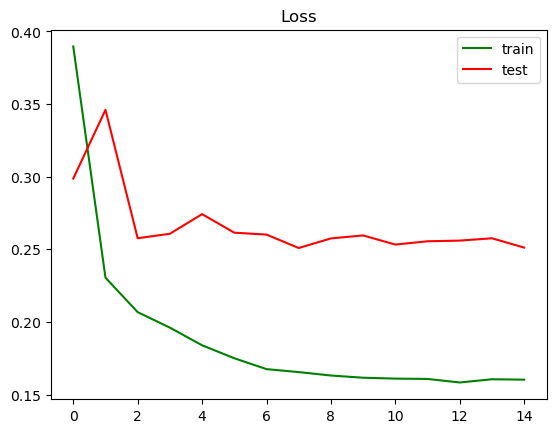

In [33]:
plt.title('Loss')
plt.plot(hRes['loss'] ,c = "green" , label='train'  )
plt.plot(hRes['val_loss'] ,c = "red" , label='test' )
plt.legend()
plt.show()

In [24]:
predictions = model1.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

500/500 [==============================] - 18s 32ms/step
[0 0 0 ... 1 1 1]


In [25]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

 closed_eyes       0.86      0.96      0.91      2000
   open_eyes       0.96      0.85      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.91      0.90      0.90      4000
weighted avg       0.91      0.90      0.90      4000



In [27]:
probabilities = model1.predict(test_data_generator)
y_pred = np.argmax(probabilities, axis = 1)

print(confusion_matrix(test_data.classes, y_pred))

500/500 [==============================] - 16s 33ms/step
[[1925   75]
 [ 306 1694]]


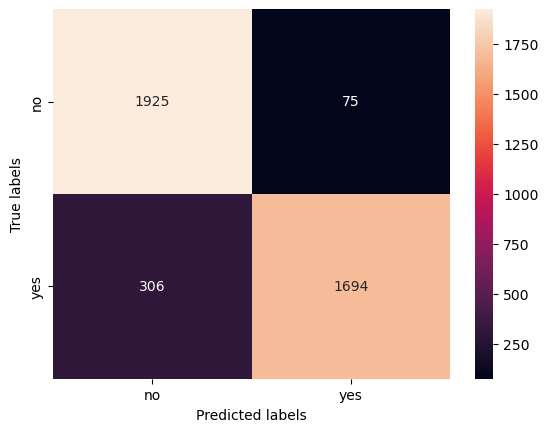

<Figure size 1200x800 with 0 Axes>

In [28]:
ax = plt.subplot() 
cf_matrix = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax= ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['no', 'yes']); ax.yaxis.set_ticklabels(['no', 'yes']);